In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

NOTE: Update the path to the data.

In [2]:
# Set the base as per your system
base_path = "../../data"
data_path = base_path + "/bs140513_032310.csv"
raw_data = pd.read_csv(data_path)
raw_cols = raw_data.columns
total_row_count = len(raw_data.index)
print("List of columns: {}".format(raw_cols))
print("Total row count: {}".format(total_row_count))

List of columns: Index(['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
       'zipMerchant', 'category', 'amount', 'fraud'],
      dtype='object')
Total row count: 594643


In [3]:
for c in raw_cols:
    col_data = raw_data[c]
    null_count = col_data.isnull().sum()
    uniq_count = col_data.nunique()
    print("\nColumn {0} details:\nNumber of unique values - {1}\nNumber of NaN rows - {2}".format(
        c, uniq_count, null_count
    ))



Column step details:
Number of unique values - 180
Number of NaN rows - 0

Column customer details:
Number of unique values - 4112
Number of NaN rows - 0

Column age details:
Number of unique values - 8
Number of NaN rows - 0

Column gender details:
Number of unique values - 4
Number of NaN rows - 0

Column zipcodeOri details:
Number of unique values - 1
Number of NaN rows - 0

Column merchant details:
Number of unique values - 50
Number of NaN rows - 0

Column zipMerchant details:
Number of unique values - 1
Number of NaN rows - 0

Column category details:
Number of unique values - 15
Number of NaN rows - 0

Column amount details:
Number of unique values - 23767
Number of NaN rows - 0

Column fraud details:
Number of unique values - 2
Number of NaN rows - 0


The columns `zipcodeOri` and `zipMerchant` have only one unqiue value which is not useful for classification problem. Hence, removing the columns.

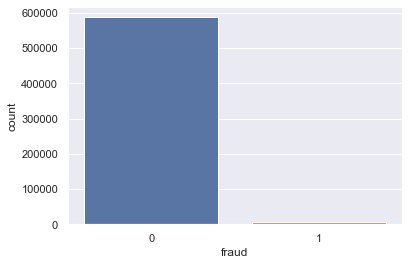

In [4]:
zip_rem_data = raw_data.drop(columns=["zipcodeOri", "zipMerchant"])
ax = sns.countplot(x="fraud", data=zip_rem_data)

NOTE: The data is heavily skewed towards authenticate transactions. We would need to use weighted class feature for the model training, along with some duplication/copy of fraud transactions to increase the row count.

In [5]:
amount_data = zip_rem_data["amount"]
mean_amount = amount_data.mean()
median_amount = amount_data.median()
print("Mean transaction amount: {0}\nMedian transaction amount: {1}".format(mean_amount, median_amount))

Mean transaction amount: 37.89013530807561
Median transaction amount: 26.9


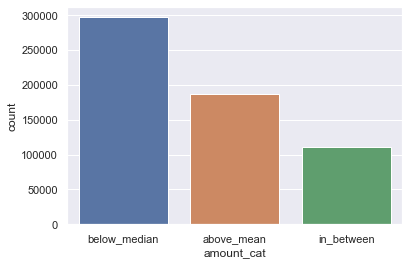

In [6]:
def cat_amount(v, mean, median):
    res = ""
    if v > mean:
        res = "above_mean"
    elif v < median:
        res = "below_median"
    elif v >= median and v <= mean:
        res = "in_between"
    return res

zip_rem_data["amount_cat"] = np.vectorize(cat_amount)\
(zip_rem_data["amount"].values, mean_amount, median_amount)

ax = sns.countplot(x="amount_cat", data=zip_rem_data, order = ["below_median", "above_mean", "in_between"])

`in_between` is the term used to describe transaction values below mean and above median value.

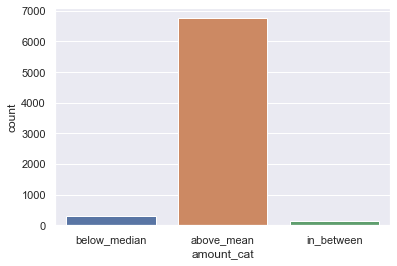

In [7]:
ax = sns.countplot(x="amount_cat", data=zip_rem_data[zip_rem_data["fraud"] == 1], order = ["below_median", "above_mean", "in_between"])

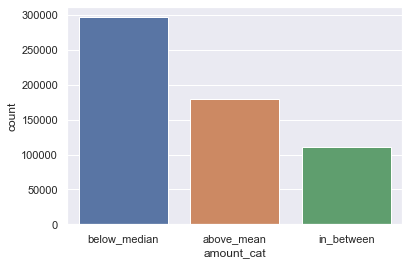

In [8]:
ax = sns.countplot(x="amount_cat", data=zip_rem_data[zip_rem_data["fraud"] == 0], order = ["below_median", "above_mean", "in_between"])

Fraudulent transactions have more tendency to be above mean transaction amount. Using the transaction amount as the three categories may improve the accuracy of the model.

Also, we remove column as we don't want our model to be biased towards gender in case the underlying data suggests the same. 

In [9]:
pre_data = zip_rem_data[["step", "customer", "age", "merchant", "category", "amount_cat", "fraud"]]
fraud_data = pre_data[pre_data["fraud"] == 1]
non_fraud_data = pre_data[pre_data["fraud"] == 0]

f_train, f_test = train_test_split(fraud_data, test_size=0.2)
nf_train, nf_test = train_test_split(non_fraud_data, test_size=0.2)

train_df = pd.concat([f_train, nf_train]).sample(frac = 1)
# Accuracy score for only the fraud rows is asked to be presented.
test_df = pd.concat([f_test, f_train]).sample(frac = 1)

X_train = train_df.iloc[:, :-1].values
y_train = train_df["fraud"].values

X_test = test_df.iloc[:, :-1].values
y_test = test_df["fraud"].values

# Transform categorical columns for training data
feat_cols = ["step", "customer", "age", "merchant", "category", "amount_cat"]
label_ens = []
for i in range(0, len(feat_cols)):
    en = LabelEncoder()
    X_train[:, i] = en.fit_transform(X_train[:, i])
    label_ens.insert(i, en)

one_hot_en = OneHotEncoder(handle_unknown='ignore')
X_train = one_hot_en.fit_transform(X_train)

# Transform categorical columns for test data
for i in range(0, len(feat_cols)):
    X_test[:, i] = label_ens[i].transform(X_test[:, i])

X_test = one_hot_en.transform(X_test)

We will be using recall score as the metric to measure our model. Due to class skewness, precision is bond to be high and hence F1 score is bond to be impacted by the underlying high precision value. 

In [10]:
# Resampling to balance the classes
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

xgb_no_res = xgb.XGBClassifier()
xgb_no_res.fit(X_train, y_train)

xgb_res = xgb.XGBClassifier()
xgb_res.fit(X_res, y_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [11]:
print("Model trained without Sampling:")
y_pred = xgb_no_res.predict(X_test)
recall = recall_score(y_test, y_pred, average="binary")
precision = precision_score(y_test, y_pred, average="binary")
f1 = f1_score(y_test, y_pred, average="binary")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Recall score for the model is {0}".format(round(recall, 4)))
print("Precision score for the model is {0}".format(round(precision, 4)))
print("F1 score for the base model is {0}".format(round(f1, 4)))
print("TP: {0}\tFP: {1}\nFN: {2}\tTN: {3}".format(tp, fp, fn, tn))

print("\nModel trained after Sampling:")
y_pred = xgb_res.predict(X_test)
recall = recall_score(y_test, y_pred, average="binary")
precision = precision_score(y_test, y_pred, average="binary")
f1 = f1_score(y_test, y_pred, average="binary")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Recall score for the base model is {0}".format(round(recall, 4)))
print("Precision score for the base model is {0}".format(round(precision, 4)))
print("F1 score for the base model is {0}".format(round(f1, 4)))
print("TP: {0}\tFP: {1}\nFN: {2}\tTN: {3}".format(tp, fp, fn, tn))

Model trained without Sampling:
Recall score for the model is 0.4022
Precision score for the model is 1.0
F1 score for the base model is 0.5737
TP: 2896	FP: 0
FN: 4304	TN: 0

Model trained after Sampling:
Recall score for the base model is 0.9832
Precision score for the base model is 1.0
F1 score for the base model is 0.9915
TP: 7079	FP: 0
FN: 121	TN: 0


Our aim to reduce all the false cases, taking aditional advantage from the graphical features.